In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy import optimize
from scipy import linalg
import scipy.optimize as so

<h6>We have a coarse grained representation of the population. For our analysis, we assume that the coarse grained representation available to us is a 2x2 next generation matrix. Further, we assume that the highest resolution description of the population is a 3x3 next generation matrix. We calculate the herd immunity threshold curve for 2x2 system -- let us call the points on this curve, the low-resolution herd immunity thresholds (HIT). Then, we investigate what happens if the 3x3 system achieves one of the low-resolution HIT -- does that translate into a high-resolution herd immunity as well?

In [3]:
##Defining the coarse grained system:
n = np.array([0.6, 0.4])
no_g = len(n)
gamma = 1 #Recovery rate
A = np.ones(no_g)
#b = np.random.uniform(low = 0, high = 4, size = (no_g, no_g)) #Transmission parameters i.e. beta_ij for groups i and j
#b = np.array([[3.5, 2, 1.6], [2, 4, 4], [1.5, 2, 0.8]])
b = np.array([[2, 3.5], [2.5, 1.5]]) #Selected arbitrary transmission matrix
NGM = ((b.T * n)/gamma).T
print('NGM = \n', NGM, '\n')


NGM = 
 [[1.2 2.1]
 [1.  0.6]] 



In [4]:
#Computing R0 and dominant eigenvector
Evalues, Evecs = np.linalg.eig(NGM)
R0 = np.max(Evalues)
V = Evecs[:, np.argmax(Evalues)]/np.sum(Evecs[:, np.argmax(Evalues)])
print('R0 and dominant E vector of the 2x2 NGM are: ', R0, V, '\n')

R0 and dominant E vector of the 2x2 NGM are:  2.3798648586948743 [0.64027028 0.35972972] 



In [5]:
def EQN(X, G11_cg, G12_cg, G21_cg, G22_cg, v1_cg, v2_cg, R0): #X = [tg, tv, G12, G13, G22, G23, G32, G33]
    tg, tv, G12, G13, G22, G23, G32, G33 = X
    return [G12*tv + G13*(1-tv) - G12_cg, (G22 + G32)*tv + (G23 + G33)*(1-tv) - G22_cg, v2_cg*(G12*tv + G13*(1-tv)) + v1_cg*(G11_cg - R0), v1_cg*G21_cg*tg + v2_cg*((G22-R0)*tv + G23*(1-tv)), v1_cg*G21_cg*(1-tg) + v2_cg*(G32*tv + (1-tv)*(G33 - R0)), 0, 0, 0]

# while True:
#     soln = so.root(EQN, np.random.rand(8), args = (NGM[0, 0], NGM[0, 1], NGM[1, 0], NGM[1, 1], V[0], V[1], R0))
#     tg, tv, G12_cg, G13_cg, G22_cg, G23_cg, G32_cg, G33_cg = soln.x
#     NGM_hr = np.array([[NGM[0, 0], G12_cg, G13_cg], [tg*NGM[1, 0], G22_cg, G23_cg], [(1-tg)*NGM[1, 0], G32_cg, G33_cg]])
#     if np.all(NGM_hr>=0) and soln.success == True:
#         break

# print(soln)
# print('A possible high resolution NG matrix is:', NGM_hr)

#Selecting an arbitrary NGM from the set of solutions
NGM_hr = np.array([[1.2, 2.85, 1.98], [.07, 1.44, 0.002], [.93, 1.35, .26]])
print('High resolution NGM: ', NGM_hr)
print('E values of the HR matrix', np.linalg.eig(NGM_hr)[0], '\n')
print('E vectors of the HR matrix', np.linalg.eig(NGM_hr)[1], '\n')

#Define group sizes and b matrix for full system
n_hr = np.array([n[0], 0.8*n[1], 0.2*n[1]])

###############################################
#b_hr = (NGM_hr*gamma/n_hr).T          ##  Incorrect calculation for b_hr
###############################################

b_hr = (NGM_hr.T*gamma/n_hr).T
print('b new:', b_hr)
print('NGM calculated again: ', (b_hr.T*n_hr/gamma).T)

High resolution NGM:  [[1.20e+00 2.85e+00 1.98e+00]
 [7.00e-02 1.44e+00 2.00e-03]
 [9.30e-01 1.35e+00 2.60e-01]]
E values of the HR matrix [-0.70698728  2.37942348  1.2275638 ] 

E vectors of the HR matrix [[ 0.73667406 -0.89701414  0.85856074]
 [-0.02338882 -0.0677698  -0.28690541]
 [-0.6758434  -0.43677556  0.42492204]] 

b new: [[2.0000e+00 4.7500e+00 3.3000e+00]
 [2.1875e-01 4.5000e+00 6.2500e-03]
 [1.1625e+01 1.6875e+01 3.2500e+00]]
NGM calculated again:  [[1.20e+00 2.85e+00 1.98e+00]
 [7.00e-02 1.44e+00 2.00e-03]
 [9.30e-01 1.35e+00 2.60e-01]]


In [7]:
#Solve HIT for 2x2 system
def growth_rate_eqn(s1, s2, b11, b12, b21, b22, g):
    return 0.5*(b11*s1 + b22*s2 - 2*g + np.sqrt((2*g - b11*s1 - b22*s2)**2 - 4*((b11*b22 - b12*b21)*s1*s2 - g*b11*s1 - g*b22*s2 + g**2)))

#Computes growth rate for any system 
def growth_rate(s, b, gamma): #This function returns the growth rate
    B = (b.T * s).T 
    M = B - np.eye(len(s))*gamma #The largest eigenvalue of M is the growth rate of the epidemic
    EV = linalg.eigvals(M)
    gr = np.amax(EV) #Growth rate
    return gr 

In [14]:
#Scanning the variable space of susceptibles, to compute the herd immunity threshold
S2 = np.arange(0.01, n[1]+0.01, 0.01)
S1 = np.array([so.root(growth_rate_eqn, np.random.rand(), args = (s2, b[0, 0], b[0, 1], b[1, 0], b[1, 1], gamma)).x[0] for s2 in S2])
#S1 = np.array(S1)
S1_plot, S2_plot = [], []
growth_rates_max = []
growth_rates_min = []

print('The susceptible population of the 2nd group in 2x2 system has to be distributed among the the 2nd and 3rd groups in the 3x3 system', '\n')
print('a% are placed in the new second group, and (1-a)% are placed in the new third group', '\n')
for k in range(0, len(S1)):
    #print(k)
    s1_req, s2_req = S1[k], S2[k]
    #s_req_hr = np.array([s1_req, s2_req/n[1]*n_hr[1], s2_req/n[1]*n_hr[2]])
    #Bounds for the parameter a, such that s<n
    bound_1 = 1-n_hr[2]/s2_req 
    bound_2 = n_hr[1]/s2_req
    #print('bounds', bound_1, bound_2)
    if bound_1 < bound_2:
        a_list = np.linspace(max(bound_1, 0), min(bound_2, 1), 10)
        #a = np.random.uniform(max(bound_1, 0), min(bound_2, 1))
    else:
        a_list = np.linspace(max(bound_2, 0), min(bound_1, 1), 10)
        #a = np.random.uniform(max(bound_2, 0), min(bound_1, 1))
    
    if np.any(a_list<0) or np.any(a_list>1):
        print('Fault')
        break
    
    S1_plot.append(s1_req)
    S2_plot.append(s2_req)
    growth_rates = []
    for a in a_list:
        s_req_hr = np.array([s1_req, a*s2_req, (1-a)*s2_req])
        growth_rates.append(np.real(growth_rate(s_req_hr, b_hr, gamma)))

    growth_rates_max.append(np.max(growth_rates))
    growth_rates_min.append(np.min(growth_rates))
    
    # if k == len(S1)-2:
    #     print('s^f = ', s_req_hr, '\n')
    #     print('Growth Rate =', growth_rate(s_req_hr, b_hr, gamma), '\n')

S1_plot = np.array(S1_plot)
S2_plot = np.array(S2_plot)



The susceptible population of the 2nd group in 2x2 system has to be distributed among the the 2nd and 3rd groups in the 3x3 system 

a% are placed in the new second group, and (1-a)% are placed in the new third group 



In [28]:
%matplotlib widget

In [30]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot3D(S1_plot, S2_plot, growth_rates_min, 'gray')
ax.plot3D(S1_plot, S2_plot, growth_rates_max, 'black')

xx, yy = np.meshgrid(S1_plot, S2_plot)
zz = np.zeros(xx.shape)
ax.plot_surface(xx, yy, zz, alpha = 0.5)

# im = ax.scatter(S1_plot[tmp], S2_plot[tmp], c = np.real(growth_rates[tmp]), cmap = 'Greys', alpha = 0.8)
# fig.colorbar(im, ax=ax, location = 'bottom')

#ax.set_xlim3d(s0[2], )
#ax.set_ylim3d(s1[2], )
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
#ax.set_xlim(0, n[0])
#ax.set_ylim(0, n[1])


# for t in np.linspace(0, 1, 20):
#     n_hr = [n[0], t*n[1], (1-t)*n[1]]
#     b_hr = (NGM_hr*gamma/n_hr).T


# t = np.random.rand()
# G21, G31 = t*NGM[1, 0], (1-t)*NGM[1, 0]
# v2, t = np.random.rand(), np.random.rand()
# v3 = t*v2
# v1 = 1 - v2*(1+t)

# print(v1, v2, v3, G21, G31)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, '$s_2$')

In [21]:
xx.shape

(40, 40)

The susceptible population of the 2nd group in 2x2 system has to be distributed among the the 2nd and 3rd groups in the 3x3 system 

a% are placed in the new second group, and (1-a)% are placed in the new third group 

0
bounds -7.000000000000002 32.00000000000001
1
bounds -3.000000000000001 16.000000000000004
2
bounds -1.6666666666666674 10.66666666666667
3
bounds -1.0000000000000004 8.000000000000002
4
bounds -0.6000000000000003 6.400000000000001
5
bounds -0.3333333333333335 5.333333333333334
6
bounds -0.14285714285714324 4.571428571428573
7
bounds -2.220446049250313e-16 4.000000000000001
8
bounds 0.11111111111111094 3.5555555555555562
9
bounds 0.19999999999999973 3.200000000000001
10
bounds 0.2727272727272726 2.9090909090909096
11
bounds 0.33333333333333315 2.6666666666666674
12
bounds 0.38461538461538447 2.461538461538462
13
bounds 0.4285714285714285 2.285714285714286
14
bounds 0.4666666666666667 2.1333333333333333
15
bounds 0.4999999999999999 2.0000000000000004
16
bounds 0.5294117

IndexError: boolean index did not match indexed array along dimension 0; dimension is 40 but corresponding boolean dimension is 10

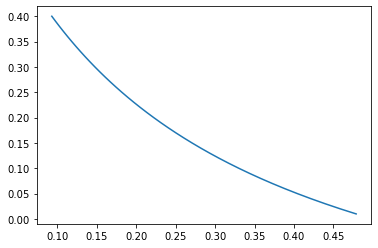

In [9]:
#Scanning the variable space of susceptibles, to compute the herd immunity threshold
S2 = np.arange(0.01, n[1]+0.01, 0.01)
S1 = np.array([so.root(growth_rate_eqn, np.random.rand(), args = (s2, b[0, 0], b[0, 1], b[1, 0], b[1, 1], gamma)).x[0] for s2 in S2])
#S1 = np.array(S1)
S1_plot, S2_plot = [], []
growth_rates_max = []
growth_rates_min = []

print('The susceptible population of the 2nd group in 2x2 system has to be distributed among the the 2nd and 3rd groups in the 3x3 system', '\n')
print('a% are placed in the new second group, and (1-a)% are placed in the new third group', '\n')
for k in range(0, len(S1)):
    print(k)
    s1_req, s2_req = S1[k], S2[k]
    #s_req_hr = np.array([s1_req, s2_req/n[1]*n_hr[1], s2_req/n[1]*n_hr[2]])
    #Bounds for the parameter a, such that s<n
    bound_1 = 1-n_hr[2]/s2_req 
    bound_2 = n_hr[1]/s2_req
    print('bounds', bound_1, bound_2)
    if bound_1 < bound_2:
        a_list = np.linspace(max(bound_1, 0), min(bound_2, 1), 10)
        #a = np.random.uniform(max(bound_1, 0), min(bound_2, 1))
    else:
        a_list = np.linspace(max(bound_2, 0), min(bound_1, 1), 10)
        #a = np.random.uniform(max(bound_2, 0), min(bound_1, 1))
    
    if np.any(a_list<0) or np.any(a_list>1):
        print('Fault')
        break
    
    S1_plot.append(s1_req)
    S2_plot.append(s2_req)
    growth_rates = []
    for a in a_list:
        s_req_hr = np.array([s1_req, a*s2_req, (1-a)*s2_req])
        growth_rates.append(np.real(growth_rate(s_req_hr, b_hr, gamma)))

    growth_rates_max.append(np.max(growth_rates))
    growth_rates_min.append(np.min(growth_rates))
    
    # if k == len(S1)-2:
    #     print('s^f = ', s_req_hr, '\n')
    #     print('Growth Rate =', growth_rate(s_req_hr, b_hr, gamma), '\n')

#print('s req full', s_req_hr, '   s1_req and s2_req', s1_req, s2_req)
S1_plot = np.array(S1_plot)
S2_plot = np.array(S2_plot)

growth_rates = np.array(growth_rates)
tmp = growth_rates>0


fig, ax = plt.subplots(1, 1)
ax.plot(S1, S2)

im = ax.scatter(S1_plot[tmp], S2_plot[tmp], c = np.real(growth_rates[tmp]), cmap = 'Greys', alpha = 0.8)
fig.colorbar(im, ax=ax, location = 'bottom')

ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
#ax.set_xlim(0, n[0])
#ax.set_ylim(0, n[1])
plt.show()

# for t in np.linspace(0, 1, 20):
#     n_hr = [n[0], t*n[1], (1-t)*n[1]]
#     b_hr = (NGM_hr*gamma/n_hr).T


# t = np.random.rand()
# G21, G31 = t*NGM[1, 0], (1-t)*NGM[1, 0]
# v2, t = np.random.rand(), np.random.rand()
# v3 = t*v2
# v1 = 1 - v2*(1+t)

# print(v1, v2, v3, G21, G31)

# #We have three more variables to solve: G22, G23, G32, G33. But only three equations are available. So we choose G22 randomly
# G22 = R0*np.random.rand() #Can lie between 0 and R0 -- think about this
# print(G22, '\n \n')

# ## Solves for G12 and G13
# def EQN1(X, v2, v3, R0, G12_cg, G11):
#     return np.array([X[0]*v2 + X[1]*v3 - G12_cg*(v2+v3), (X[0] - G11 + R0)*v2 + (X[1] - G11 + R0)*v3 + G11 - R0])

# print('G12 and G13: \n', so.root(EQN1, np.random.rand(2), args = (v2, v3, R0, NGM[0, 1], G11)))



# ## Solves for X = [G23, G32, G33]
# def EQN2(X, v2, v3, R0, G21, G22, G31, G22_cg):
#     return np.array([(G22 - G21 - R0)*v2 + (X[0] - G21)*v3 + G21, (X[1]-G31)*v2 + (X[2]-G31-R0)*v3 + G31, (G22+X[1])*v2 + (X[2]+X[0])*v3 - G22_cg*(v2+v3)])

# print('\n G23, G32 and G33: \n', so.root(EQN2, np.random.rand(3), args = (v2, v3, R0, G21, G22, G31, NGM[1, 1])))

#constraint21 = optimize.NonlinearConstraint(lambda x: x[0]+x[1] - NGM[1, 0], lb=0, ub=0)
#constraint_positive = optimize.NonlinearConstraint(lambda x: x, lb=0, ub=np.inf)
#constraint21 = optimize.NonlinearConstraint(lambda x: x[0]+x[1] - NGM[1, 0], lb=0, ub=0)

##############################################################################################
# NGM_cg = np.zeros((2, 2))
# NGM_cg[0, 0], NGM_cg[0, 1], NGM_cg[1, 0] = NGM[0, 0], np.sum(NGM[0, 1:]*V[1:])/np.sum(V[1:]), np.sum(NGM[1:, 0])
# NGM_cg[1, 1] = np.sum([NGM[k, l]*V[l] for k in range(1, no_g) for l in range(1, no_g)])/np.sum(V[1:])

# Evalues, Evecs = np.linalg.eig(NGM)
# R0_cg = np.max(Evalues)

# n_cg = np.array([n[0], np.sum(n[1:])])
# no_g_cg = len(n_cg)
# b_cg = (NGM_cg*gamma/n_cg).T
# A_cg = np.ones(no_g_cg)
# NGM_cg, n_cg, b_cg
# #V = Evecs[:, np.argmax(Evalues)]/np.sum(Evecs[:, np.argmax(Evalues)])

# root_ord = so.root(FS, 0.9*n, args = (b, n, gamma)) #Using a numerical solver to find the final size
# FS_ord = root_ord.x #The final sizes without intervention